In [ ]:
import requests
from IPython.core.display import HTML
HTML(f"""
<style>
@import "https://cdn.jsdelivr.net/npm/bulma@0.9.4/css/bulma.min.css";
</style>
""")

# Learning an Affine Transformation
<figure class="figure" id="names">

<img src="/resources/material/W04/affine_overview.svg" class="figure-img img-fluid rounded" style="width:40%" />

<figcaption class="figure-caption has-text-centered">Figure 1: Naming the planes and transformation</figcaption>
</figure>

Assume that an affine mapping is sufficient  to transform image coordinates  of a 
person walking in the atrium at ITU to an overview map (image) of the ground-floor of ITU. The goal of this exercise is learn the coefficients of the affine mapping given training data and then subsequently map the tracking coordinates for the person in the video is given in `trackingdata.dat`
.
As shown in [Figure 1](#names), denote
1. the video `ITUStudent.mov`
  by $V$, 
2. the ground-floor in $V$ by $G$ 
3. the ground-plane of ITU building by $M$
4. The affine transformation ${T}_G^M$ from the ground-floor $G$ to the overview map $M$.

Your goal is to learn the coefficients of the affine transformation and use it to map the tracking data to the overview map. 
Hence, your task is to:
1. Learn the coefficients of the affine transformation  ${T}_G^M$ and
2. Apply the mapping ${T}_G^M$ to transform the tracking data from the ground-floor $G$ in $V$ to $M$ and display the location of the person on the ground-floor.

## Overview
<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">
<div style="float: right; width: 30%; justify-content: start" class="block is-clearfix">
<figure class="figure" id="points">

<img src="/resources/material/W04/tracking_data.svg" class="figure-img img-fluid rounded" style="width:100%" />

<figcaption class="figure-caption has-text-centered">Figure 2: The three sub-regions of the person being tracked.</figcaption>
</figure>


</div>

Your main task is to implement the function `calc_affine()`
 that given points in $V$ and $M$, returns the corresponding affine transformation matrix $T$.
The 3 pairs of corresponding points (for calibration) and tracking data are provided in the `data/`
 folder. The tracking data is loaded from `trackingdata.dat`
 where each row $r_i$ in the 
file is contains tracking coordinates (as shown in [Figure 2](#points)) for frame $f_i$ in the video `ITUStudent.mov`
.
Each rectangle is defined by a  coordinates pair $(x_1, y_1)$ and $(x_2, y_2)$ corresponding to the top left and 
bottom right hand corners of the rectangle. The rectangles for specific bodyparts are stored  in a dictionary `data`
 that has keys _body_, _legs_, and _all_. 
to  access the arrays of the corresponding bodyparts.

</div>

### Background on Affine mappings
An affine mapping  $T$ is given by

$$ T = 
\begin{bmatrix}
    w_1 & w_2 & w_3 \\
    w_4 & w_5 & w_6 \\
    0 & 0 & 1
\end{bmatrix},
$$

where $T$  transforms points between the planes by $p^{\prime} = T p$ and 
$p$ and $p^{\prime}$ are 2D  homogeneous coordinates.
Estimating the coefficients in $T$ is linear. Define $\mathbf{w}$ as the vector of coefficients:

$$\mathbf{w} = \begin{bmatrix} w_1 \\ w_2 \\ w_3\\ w_4 \\ w_5 \\ w_6 \end{bmatrix}.$$

The goal is to estimate $\mathbf{w}$ given corresponding point pairs from $G$ and $M$.

---
**Task 1 (medium)♾️**
This task is divided into a step showing the linear relation between a single point pair and a step extending this to multiple point pairs.
1. Given an input $p=\begin{bmatrix} x \\ y \\1\end{bmatrix}$ and output $p'=\begin{bmatrix} x' \\ y' \\1\end{bmatrix}$, explain how the unknowns $\mathbf{w}$ of the affine mapping can be isolated into a vector and the relation be rewritten to the form $A_1\mathbf{w}=b_1$ where

$$A_1=\begin{bmatrix}
        x & y & 1 & 0 & 0 & 0 \\
        0 & 0 & 0 & x & y & 1 \\
        \end{bmatrix},\quad
        \mathbf{w}=
        \begin{bmatrix}
        w_1 \\
        w_2 \\
        w_3 \\
        w_4 \\
        w_5 \\
        w_6
    \end{bmatrix}
    ,\quad
    b_1=\begin{bmatrix}
        x^{\prime} \\
        y^{\prime} \\
        \end{bmatrix}.
    $$


This means that a pair of corresponding points yield two equations. 

**Answer:** We can do this by taking the inverse of the design matrix $A$. However, it is not a square matrix yet so we cannot take the inverse for now. 

2. Argue why (exactly) $3$ pairs of corresponding points are needed to solve for the unknowns $\mathbf{w}$.

**Answer:** Because we have the 6 unknowns but we have 2 equations in the matrix $A_1$ we can add 4 more lines in the matrix and have 6 equations for the 6 unknowns.

3. Show that the unknowns $\mathbf{w}$ can be by solved through  $\mathbf{w} = A^{-1}b$,  where $A$ is the design matrix

$$A = \begin{bmatrix}
        x_1 & y_1 & 1 & 0 & 0 & 0 \\
        0 & 0 & 0 & x_1 & y_1 & 1 \\
        x_2 & y_2 & 1 & 0 & 0 & 0 \\
        0 & 0 & 0 & x_2 & y_2 & 1 \\
        x_3 & y_3 & 1 & 0 & 0 & 0 \\
        0 & 0 & 0 & x_3 & y_3 & 1
    \end{bmatrix},
     b = \begin{bmatrix}
        x_1^{\prime} \\
        y_1^{\prime} \\
        x_2^{\prime} \\
        y_2^{\prime} \\
        x_3^{\prime} \\
        y_3^{\prime}
    \end{bmatrix}.$$

**Answer:** $Ax=b => A^{-1}Ax=bA^{-1} => x=A^{-1}b$




---
A pre-selected set of 3 point pairs (in the different planes) are loaded:


In [2]:
# importing needed libraries
import matplotlib.pyplot as plt
import numpy as np
import skimage

#### loading data
points_source = np.load('data/points_source.npy')
points_destination = np.load('data/points_destination.npy')

The 3 pairs of points are visualized in the following cell:


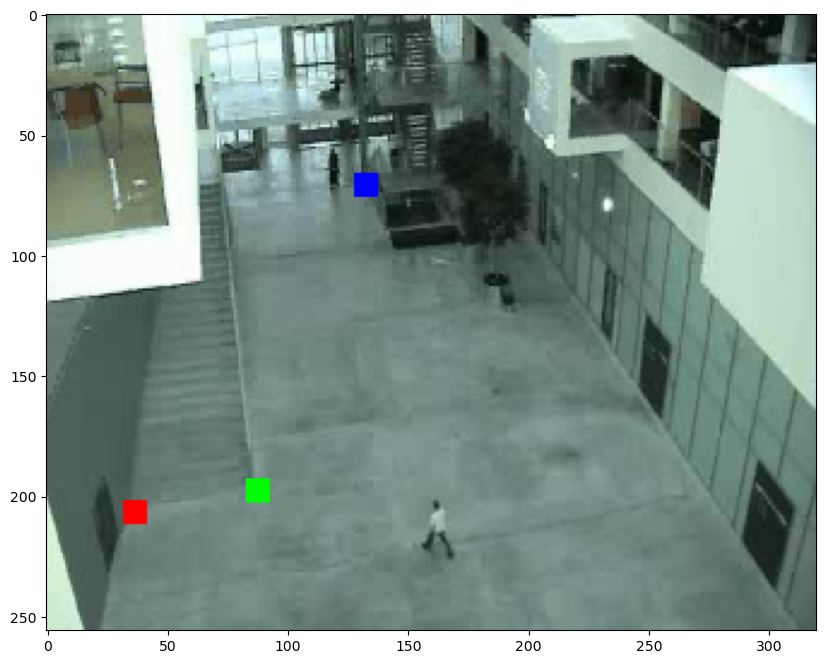

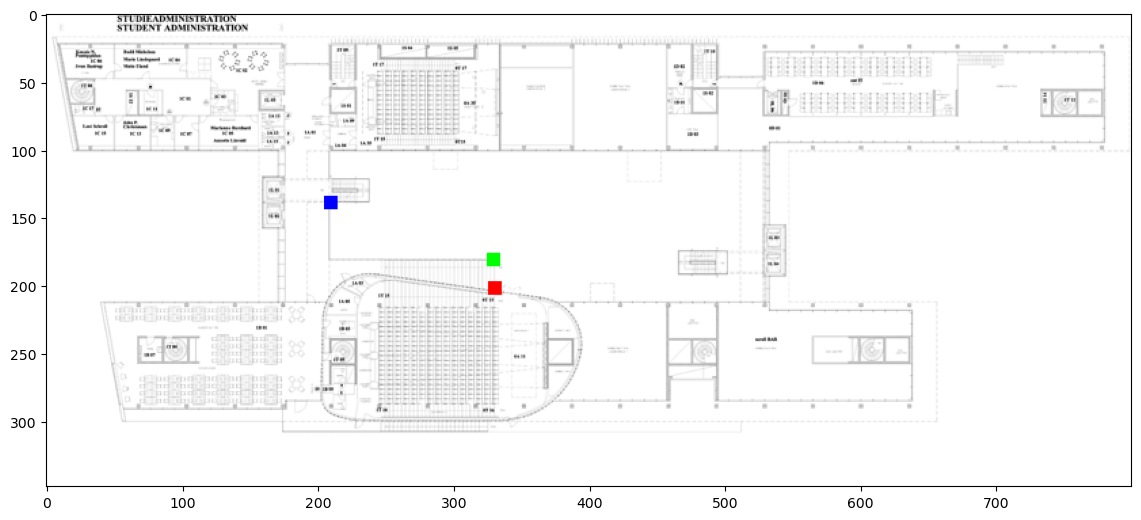

In [3]:
ITU_image = skimage.io.imread('data/image_ground.jpg')
ITU_RGB = ITU_image[:, :, :3]
plt.figure(figsize=(14, 8))
ITU_RGB[int(points_source[0, 1]) - 5:int(points_source[0, 1]) + 5,
int(points_source[0, 0]) - 5:int(points_source[0, 0]) + 5] = np.array([255, 0, 0])
ITU_RGB[int(points_source[1, 1]) - 5:int(points_source[1, 1]) + 5,
int(points_source[1, 0]) - 5:int(points_source[1, 0]) + 5] = np.array([0, 255, 0])
ITU_RGB[int(points_source[2, 1]) - 5:int(points_source[2, 1]) + 5,
int(points_source[2, 0]) - 5:int(points_source[2, 0]) + 5] = np.array([0, 0, 255])
plt.imshow(ITU_RGB)

ITU_Map = plt.imread('data/ITUMap.png')
plt.figure(figsize=(14, 8))
Map_RGB = ITU_Map[:, :, :3]
Map_RGB[int(points_destination[0, 1]) - 5:int(points_destination[0, 1]) + 5,
int(points_destination[0, 0]) - 5:int(points_destination[0, 0]) + 5] = np.array([1, 0, 0])
Map_RGB[int(points_destination[1, 1]) - 5:int(points_destination[1, 1]) + 5,
int(points_destination[1, 0]) - 5:int(points_destination[1, 0]) + 5] = np.array([0, 1, 0])
Map_RGB[int(points_destination[2, 1]) - 5:int(points_destination[2, 1]) + 5,
int(points_destination[2, 0]) - 5:int(points_destination[2, 0]) + 5] = np.array([0, 0, 1])
plt.imshow(Map_RGB);

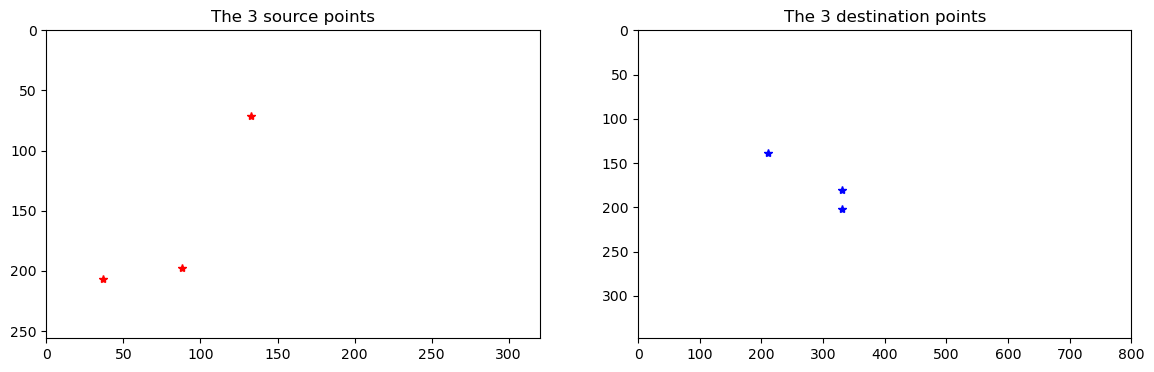

In [4]:
### We can also visualize the points by them self
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1), plt.plot(points_source[:, 0], points_source[:, 1], 'r*'), plt.ylim(256, 0), plt.xlim(0,
                                                                                                           320), plt.title(
    'The 3 source points')
plt.subplot(1, 2, 2), plt.plot(points_destination[:, 0], points_destination[:, 1], 'b*'), plt.ylim(348, 0), plt.xlim(0,
                                                                                                                     800), plt.title(
    'The 3 destination points')
plt.ylim(348, 0);

# Implement learning of the affine model
Denote  $P_{i}^{G}$ and $P_{i}^{M}$ the points in the ground plane $G$ (`point_source`
) and the overview map $M$ (`points_destination`
). Your task is to create a function that estimates the parameters $\mathbf{w}$ of the affine model using $P_{i}^{G}$ and $P_{i}^{M}$.

---
**Task 2 (medium): Implement👩‍💻**
Implement the function `calc_affine`
 in the cell below. The function should:
- Create the design matrix $A$ 
- Estimate the parameters $\mathbf{w}$ using the inverse $A^{-1}$
- Return the affine transformation matrix $T$


---


In [8]:
### affine tranformation creation

def calc_affine(points_source, points_destination):
    """
    Estimate the affine transformation matrix using the corresponding points pairs
    
    Args:
        points_source: Points in the video 
        points_destination: Corresponding points in the map

    Returns:
        The affine matrix T
    """
    # A = np.array()
    print(points_destination)
    return None # Replace

T = calc_affine(points_source, points_destination)
print('The affine Trasformation Matrix:\n', T)

[[331. 202.]
 [330. 181.]
 [210. 139.]]
The affine Trasformation Matrix:
 None


### Estimate points in the overview map
You will use the transformation to display the path walked by a 
student in the overview map. `load_data()`
 (provided in the cell below) is used to generate the `data`
 the dictionary with the different regions of the tracked person in the $G$ view.
All the entries in `data`
 contain points $(x_i, y_i, x_i, y_i)$ in a $N\times 4$ 
array, i.e. the points for the $i$th frame can be accessed using `data[i]`
.


In [ ]:
def load_data():
    """Loads the tracking data."""
    filename = "data/trackingdata.dat"
    data = np.loadtxt(filename)
    data = {"body": data[:, :4], "legs": data[:, 4:8], "all": data[:, 8:]}

    return data


### Load data 
data = load_data()

In [ ]:
### Needed functions

def to_homogeneous(points):
    if len(points.shape) == 1:
        points = points.reshape((*points.shape, 1))
    return np.vstack((points, np.ones((1, points.shape[1]))))


def to_euclidean(points):
    return points[:2] / points[2]


def get_center(part, i):
    """Returns center of body part in homogeneous coordinates.

    Parameters: part refers to a Nx4 array containing rectangle points for a specific
    body part. i refers to the frame index to fetch.
    """
    x = int((part[i, 0] + part[i, 2]) / 2)
    y = int((part[i, 1] + part[i, 3]) / 2)

    return to_homogeneous(np.array([x, y]))


---
**Task 3 (easy): Implement `apply_affine`
**
Implement the function `apply_affine`
 such that it:
- Transforms `point`
 into homogeneous coordinates using the `to_homogeneus`
 function. 
- Transforms the point using the transformation matrix `T`
. 
- Returns the result as a Euclidean coordinate (use the `to_euclidean`
 function).


---


In [ ]:
def apply_affine(T, point):
    """Apply affine transformation T to point.
    
    Args:
        T: the affine transformation
        point: the point to transform

    Returns:
        the transformed point p'
    """
    return None # Replace


---
**Task 4 (medium): Transform points👩‍💻**
Implement `transform_points`
. It should:
- Use `get_center`
 to get the center point for all the points in `data`
 for the specified body `part`
.
- Apply the affine transformation `T`
 to the center points using the `apply_affine`
 function.


**Tip**
Iterate over the tracking `data`
 and transform the body part center for each frame.



---


In [ ]:
def transform_points(part, data, T):
    """
    Apply affine transformation to all points in tracking data for a specific part
    
    Args:
        part: body part 
        data: point data
        T: transformation matrix

    Returns:

    """
    return None # Replace

### Use your recently created function to transform the tracking data
G_points, M_points = transform_points("legs", data, T)


---
**Task 5 (medium): Plot results👩‍💻💡**
The cell below visualizes the `G_points`
 and `M_points`
 calculated above.
1. Modify the code to plot the tracking data for all the different body parts.
2. Compare to the video, to gauge the quality of the transformation.    - Which body part is the most accurate?


3. What are the limitations to the approach used in this exercise?    - How can the accuracy be improved?




**Hint**
Is the model sensitive to the 3 selected point pairs?




---


In [ ]:
#### Visualize transformed points
plt.figure(figsize=(14, 6))
plt.plot(points_destination[:, 0], points_destination[:, 1], 'b*', label="3 points for transformation estimation")
plt.plot(M_points[:, 0], M_points[:, 1], 'g.', label="tracked person")
plt.ylim(348, 0)
plt.xlim(0, 800)
plt.title('ITU MAP plane')
plt.legend()
plt.show()

##### orignal plane visualization

plt.figure(figsize=(8, 6))
plt.plot(points_source[:, 0], points_source[:, 1], 'b*', label="3 points for transformation estimation")
plt.plot(G_points[:, 0], G_points[:, 1], 'g.', label="tracked person")
plt.ylim(256, 0), plt.xlim(0, 320)
plt.title('Video plane')
plt.legend()
plt.show()